# Precipitation histograms in new WoFS simulations

## Setup

In [ ]:
# Import statements
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import cartopy.crs as ccrs


from matplotlib.ticker import FuncFormatter

### New WoFS

In [9]:
def get_wofs_all(init: int) -> xr.Dataset:
    """Read in WoFS output based on initialization time."""
    file_pattern = f"/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc"
    loaded = xr.open_mfdataset(
        file_pattern, combine="nested", concat_dim="time", chunks="auto"
    )

    if init < 6:
        start_time = f"2021-09-02 {init:02d}:00:00"
        end_time = f"2021-09-02 {init + 6:02d}:00:00"
    elif init == 17:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-01 {init + 6:02d}:00:00"
    else:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-02 {init - 24 + 6:02d}:00:00"

    loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
    return loaded

def get_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Return a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [w[varname].sel(time=slice(start_time, end_time)) for w in wofs_list],
        dim=init_dim,
    ).chunk({"init": -1})

def get_total_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Calculate the sum of a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [
            w[varname].sel(time=slice(start_time, end_time)).sum(dim="time")
            for w in wofs_list
        ],
        dim=init_dim,
    ).chunk({"init": -1})

In [11]:
# Load in 20-23Z initializations
wofs_all = [get_wofs_all(i) for i in [20, 21, 22, 23]]

# Define variables and parameters
lat = wofs_all[0].xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs_all[0].xlon.isel(time=0).squeeze().drop_vars("time")

# Set up Cartopy projection

proj = ccrs.LambertConformal(
    central_longitude=wofs_all[0].attrs["CEN_LON"],
    central_latitude=wofs_all[0].attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # WoFS projection

# Create a DataArray for the initialization dimension

init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z"], dims="init").assign_coords(
    {"init": ["20Z", "21Z", "22Z", "23Z"]}
)


In [12]:
# Get the 01 to 02 UTC rainfall
rain12 = get_total_field(
    wofs_all, "rain", "2021-09-02 01:05:00", "2021-09-02 02:00:00", init_dim=init
)
# rain01 = get_total_field(wofs_all, "rain", "2021-09-02 00:05:00", "2021-09-02 01:00:00", init_dim=init)

# Calculate standard deviation of rainfall
std = rain12.std(dim=("init", "ne"))

# Lastly, make our area of interest where sd > 65% of max sd
aoi = std > (std.max() * 0.65)

rain12_aoi = rain12.where(aoi).mean(dim=("lat", "lon"), skipna=True)


### Create Wet and Dry Ensembles

In [9]:
# Get the indices of the wettest and driest ensemble members
ne_wet = [
    r.ne.where(r > r.quantile(0.75, dim="ne")).dropna(dim="ne").drop_vars("quantile")
    for r in rain_0102_point
]
ne_dry = [
    r.ne.where(r < r.quantile(0.25, dim="ne")).dropna(dim="ne").drop_vars("quantile")
    for r in rain_0102_point
]

### NYC and area max rainfall

In [26]:
wofs_wet = [wofs_all[i].sel(ne=ne_wet[i].astype(int)) for i in range(len(wofs_all)-1)]
wofs_dry = [wofs_all[i].sel(ne=ne_dry[i].astype(int)) for i in range(len(wofs_all)-1)]

In [27]:
# Function to overwrite ne values
def overwrite_ne(da:xr.DataArray|xr.Dataset) -> xr.DataArray|xr.Dataset:
    da["ne"] = range(5)
    return(da)

In [30]:
# Make a new DataArray
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z", "00Z"], dims="init")
init = init.assign_coords({"init": init})

rain_0102_wet = (
    xr.concat([overwrite_ne(w.rain) for w in wofs_wet], dim=init)  # type:ignore
    .sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00"))
    .sum(dim="time")
    .max(dim=["lat", "lon"])
    .chunk("auto")
    .stack(run=("init", "ne"))
)
rain_0102_dry = (
    xr.concat([overwrite_ne(w.rain) for w in wofs_dry], dim=init)  # type: ignore
    .sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00"))
    .sum(dim="time")
    .max(dim=["lat", "lon"])
    .chunk("auto")
    .stack(run=("init", "ne"))
)

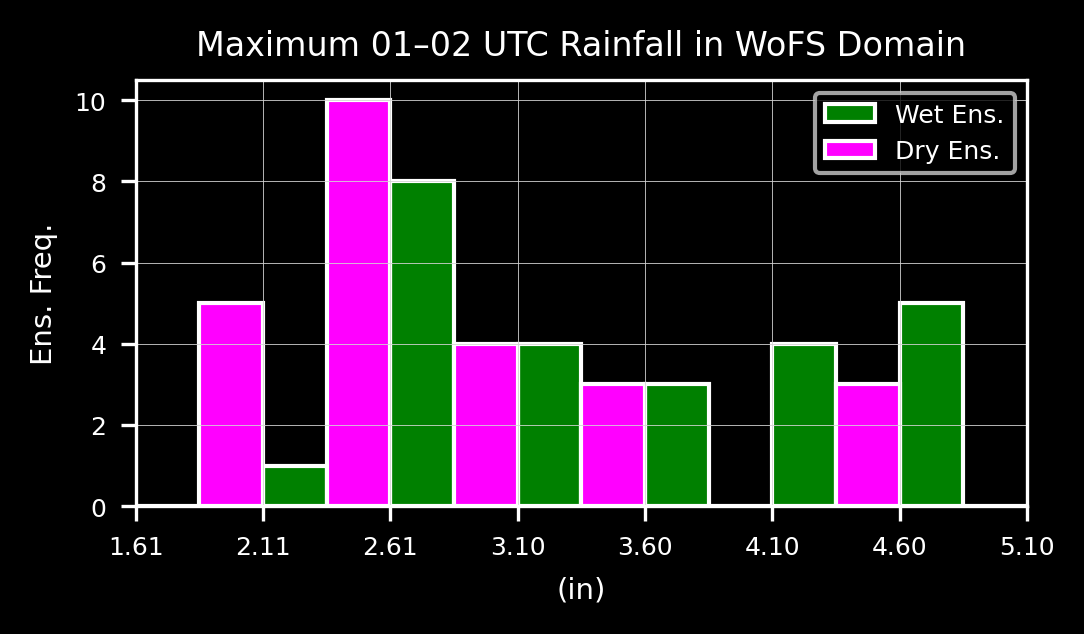

In [34]:
plt.style.use("dark_background")
bins = np.histogram_bin_edges(
    np.concat([rain_0102_wet.values, rain_0102_dry.values]), bins="auto"
)

# Make a list of titles
title = "Maximum 01–02 UTC Rainfall in WoFS Domain"

# Function to format the x-tick labels to two decimal points
def two_decimal_formatter(x, pos):
    return f"{x:.2f}"

# Make a 1 x 1 figure with a histogram of 1-2 UTC rainfall for each initialization
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    sharex=True,
    sharey=True,
    dpi=300,
    figsize=(3.5, 2),
    layout="constrained",
)

# Width for the bars in the histograms
bar_width = (bins[1] - bins[0]) / 2

# Extract the data for the current initialization
wet_data = rain_0102_wet.values
dry_data = rain_0102_dry.values

# Compute the histogram
wet_hist, _ = np.histogram(wet_data, bins=bins)
dry_hist, _ = np.histogram(dry_data, bins=bins)

# Plot the histograms
ax.bar(
    bins[:-1],
    wet_hist,
    width=bar_width,
    align="edge",
    edgecolor="white",
    color="green",
    label="Wet Ens.",
)
ax.bar(
    bins[:-1] + bar_width,
    dry_hist,
    width=bar_width,
    align="edge",
    edgecolor="white",
    color="magenta",
    label="Dry Ens.",
)

ax.xaxis.set_tick_params(which="both", labelbottom=True)
ax.tick_params(axis="both", labelsize=6)
ax.set_xticks(bins)
ax.set_yticks(range(0,12,2))
ax.yaxis.set_tick_params(which="both", labelleft=True)
ax.grid(color="lightgray", linewidth=0.2)
ax.set_title(title, fontsize=8)
ax.set_xlabel("")

# Set the x-axis formatter to round to two decimal points
ax.xaxis.set_major_formatter(FuncFormatter(two_decimal_formatter))

ax.set_ylabel("Ens. Freq.", fontsize=7)

# Set the x-axis labels for the bottom row of plots
ax.set_xlabel("(in)", fontsize=7)

# Set the x-axis limit
plt.xlim(bins.min(), bins.max())

# Add a legend to the plot
ax.legend(fontsize=6)

# Show the plot
plt.show()